# ccdproc-04:   BIAS correction

## Overview
1. Manually substract BIAS 
2. Analysing the results
3. Using master BIAS to correct from BIAS all the images

<pre>
Máster en Astrofísica UCM  -- Técnicas Experimentales en Astrofísica  
Jaime Zamorano and Nicolás Cardiel

This notebook has reproduced parts of the the astropy ccdproc docs: 
https://ccdproc.readthedocs.io/en/latest/reduction_toolbox.html#subtract-bias-and-dark

Version 1.0 2021/01/15  
</pre>

Note that the ``astropy`` package should be installed. In this sense, have a look to the
astropy installation description: https://docs.astropy.org/en/stable/install.html.

In [27]:
from pathlib import Path
import datetime

import matplotlib.pyplot as plt

import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.io import fits
from astropy import units as u
from astropy.nddata import CCDData

import ccdproc

In [28]:
plt.style.use('./tea.mplstyle')

### Working with images in a directory
We will use the files of the first night of observations at NOT (Nordic Optical Telescope) 2008 that can be downloaded from   ftp://astrax.fis.ucm.es/pub/users/jaz/NOT_2008_04_12-14/N1/
or 
http://guaix.fis.ucm.es/~jaz/master_TEA/observaciones_NOT_2008/N1/

``directory`` should point to the working directory.  


At this step we have already created a combination of BIAS frames with the result of a master DARK that we called zero_N1.fits. This file should be in our working directory that also contents the trimmed images.  

In [29]:
dirname = 'N1'   # change the path to your working directory
directory = Path(dirname)

Let\'s create a list containing all the FITS files in that directory.  
We asume that the images were already trimmed and their names begin with 't_' (see previous notebooks 'ccdproc_02' and 'ccdproc_03')

In [30]:
filelist = list(sorted(directory.glob('t_*.fits')))
print(filelist[10:20])    # printing only from 10 to 20

[PosixPath('N1/t_ALrd120011.fits'), PosixPath('N1/t_ALrd120012.fits'), PosixPath('N1/t_ALrd120013.fits'), PosixPath('N1/t_ALrd120014.fits'), PosixPath('N1/t_ALrd120015.fits'), PosixPath('N1/t_ALrd120016.fits'), PosixPath('N1/t_ALrd120017.fits'), PosixPath('N1/t_ALrd120018.fits'), PosixPath('N1/t_ALrd120019.fits'), PosixPath('N1/t_ALrd120020.fits')]


### Statistics and display

#### Reading the master  BIAS file 

In [31]:
filename = 'zero_N1.fits'
master_bias = CCDData.read(directory / filename)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


#### Reading some example the files

In [32]:
science = CCDData.read(filelist[102])    # file with a science observation
onebias = CCDData.read(filelist[9])      # file with a single BIAS frame

Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


#### Analysing the images data

In [33]:
print('Filename          Object            exp  Mean std min  max')
print(science.header['FILENAME'], science.header['OBJECT'], science.header['EXPTIME'], 
          int(np.mean(science)), int(np.std(science)), np.min(science), np.max(science))
print(onebias.header['FILENAME'], onebias.header['OBJECT'], onebias.header['EXPTIME'], 
          int(np.mean(onebias)), int(np.std(onebias)), np.min(onebias), np.max(onebias))

Filename          Object            exp  Mean std min  max
t_ALrd120104.fits GC4496A R 3x300s 300.0 1791 632 342 65535
t_ALrd120010.fits Bias afternoon 0.0 358 6 319 7516


The science image of this example is one of the three 300s exposure observations of NGC4496A. The maximum value is 65535 which means that there is saturation in some pixels of the image. This is the highest number that can be represented by an unsigned 16-bit binary number (2^16 -1)

#### Display of the example files

In [34]:
# auxiliary function to display a rectangle and compute mean value within it
def draw_rectangle(ax, image_data, x1, x2, y1, y2, color, text=False):
    ax.plot((x1, x1), (y1, y2), color, lw=1)
    ax.plot((x2, x2), (y1, y2), color, lw=1)
    ax.plot((x1, x2), (y1, y1), color, lw=1)
    ax.plot((x1, x2), (y2, y2), color, lw=1)
    if text:
        media = image_data[y1:y2,x1:x2].mean()
        std   = image_data[y1:y2,x1:x2].std()
        ax.text((x1+x2)/2, y1+(y2-y1)/8, str(int(media)), 
                ha='center', va='center', color=color, fontsize=12)        
        ax.text((x1+x2)/2, y2-(y2-y1)/8, str(round(std,1)), 
                ha='center', va='top', color=color, fontsize=12)
    return media, std

(1774.0871333333334, 47.679584345270655)

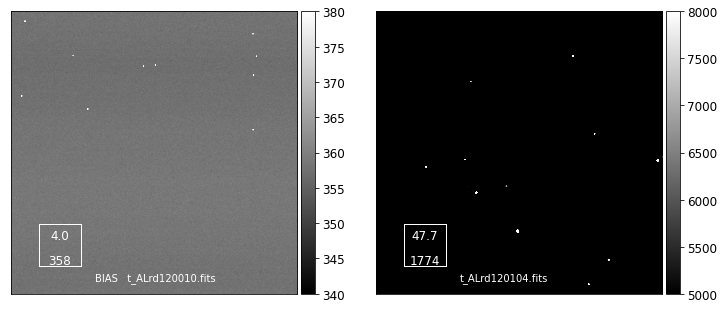

In [35]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 9))
ax0 = axarr[0]
img = ax0.imshow(onebias, vmin=340,vmax=380)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.text(600, 100, 'BIAS   '+onebias.header['FILENAME'], fontsize=10, color='w')
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax) #, label='Number of counts')
draw_rectangle(ax0, onebias.data , 200, 500, 200, 500, color='w',text=True)
ax1 = axarr[1]
img = ax1.imshow(science, vmin=5000,vmax=8000)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(600, 100, science.header['FILENAME'], fontsize=10, color='w')
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(img, cax=cax) #, label='Number of counts')
draw_rectangle(ax1, science.data , 200, 500, 200, 500, color='w',text=True)


### Manually substracting the master BIAS 

Although we will use ``ccdproc.subtract_bias`` let's substract the master BIAS from both images just to show that the procedure is a simple substraction.

In [36]:
onebias_minus_bias = np.subtract(onebias, master_bias)
science_minus_bias = np.subtract(science, master_bias)

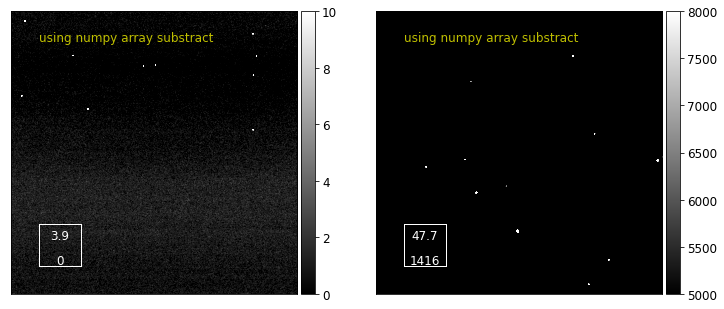

In [37]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 9))
images = [onebias_minus_bias,science_minus_bias]
cuts = [0,10,5000,8000]
for i in range(2):
    ax = axarr[i]
    vmin = cuts[0+2*i]
    vmax = cuts[1+2*i]
    img = ax.imshow(images[i].data, vmin=vmin,vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ax.text(200, 1800, 'using numpy array substract', fontsize=12, color='y')
    fig.colorbar(img, cax=cax) #, label='Number of counts')
    draw_rectangle(ax, images[i] , 200, 500, 200, 500, color='w',text=True)

As expected, the BIAS substracted BIAS has signal around 0 and the standard deviation does not change. For the science data, the result is a frame with lower signal (around 358 counts).

### Using ccdproc_substract_bias 

In [38]:
bias_subtracted_onebias = ccdproc.subtract_bias(onebias, master_bias)
bias_subtracted_science = ccdproc.subtract_bias(science, master_bias)

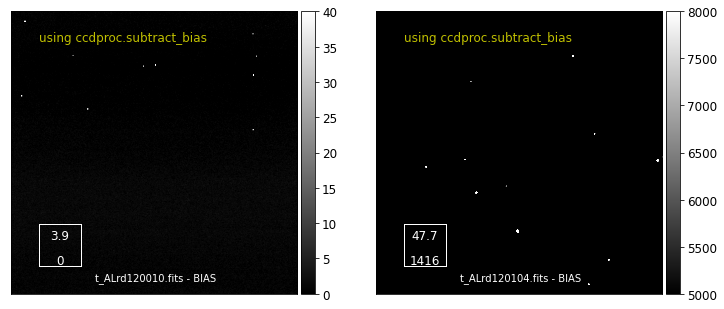

In [39]:
fig, axarr = plt.subplots(ncols=2, nrows=1, figsize=(12, 9))
images = [bias_subtracted_onebias,bias_subtracted_science]
cuts = [0,40,5000,8000]
for i in range(2):
    ax = axarr[i]
    vmin = cuts[0+2*i]
    vmax = cuts[1+2*i]
    img = ax.imshow(images[i].data, vmin=vmin,vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(600, 100, images[i].header['FILENAME']+' - BIAS', fontsize=10, color='w')
    ax.text(200, 1800, 'using ccdproc.subtract_bias', fontsize=12, color='y')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax) #, label='Number of counts')
    draw_rectangle(ax, images[i].data , 200, 500, 200, 500, color='w',text=True)

## Correcting all files from BIAS

In [40]:
for filename in filelist:
    image = CCDData.read(filename) #, unit="adu")
    z_image = ccdproc.subtract_bias(image, master_bias)
    name_of_file = f'z{image.header["FILENAME"]}'
    z_image.header['FILENAME'] = name_of_file
    nowtime = datetime.datetime.now().isoformat('T', timespec='seconds')
    z_image.header['HISTORY'] = f'{nowtime} astropy ccdproc substract_bias'
    z_image.header['HISTORY'] = 'using NOT2008/N1/zero_N1.fits master BIAS' 
    #print(f'writting {name_of_file} in {directory}')
    z_image.write(directory / name_of_file,overwrite='yes')

N1/t_ALrd120001.fits
N1/t_ALrd120002.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120003.fits
N1/t_ALrd120004.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120005.fits
N1/t_ALrd120006.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120007.fits
N1/t_ALrd120008.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120009.fits
N1/t_ALrd120010.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120011.fits
N1/t_ALrd120012.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120013.fits
N1/t_ALrd120014.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120015.fits
N1/t_ALrd120016.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120017.fits
N1/t_ALrd120018.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120019.fits
N1/t_ALrd120020.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120021.fits
N1/t_ALrd120022.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120023.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120024.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120025.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120026.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120027.fits
N1/t_ALrd120028.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120029.fits
N1/t_ALrd120030.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120031.fits
N1/t_ALrd120032.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120033.fits
N1/t_ALrd120034.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120035.fits
N1/t_ALrd120036.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120037.fits
N1/t_ALrd120038.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120039.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120040.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120041.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120042.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120043.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120044.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120045.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120046.fits
N1/t_ALrd120047.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120048.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120049.fits
N1/t_ALrd120050.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120051.fits
N1/t_ALrd120052.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120053.fits
N1/t_ALrd120054.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120055.fits
N1/t_ALrd120056.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120057.fits
N1/t_ALrd120058.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120059.fits
N1/t_ALrd120060.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120061.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120062.fits
N1/t_ALrd120064.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120065.fits
N1/t_ALrd120066.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120067.fits
N1/t_ALrd120068.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120069.fits
N1/t_ALrd120070.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120071.fits
N1/t_ALrd120072.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120073.fits
N1/t_ALrd120074.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120075.fits
N1/t_ALrd120076.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120077.fits
N1/t_ALrd120078.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120079.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120080.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120081.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120082.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120083.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120084.fits
N1/t_ALrd120085.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120086.fits
N1/t_ALrd120087.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120088.fits
N1/t_ALrd120089.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120090.fits
N1/t_ALrd120091.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120092.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120093.fits
N1/t_ALrd120094.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120095.fits
N1/t_ALrd120096.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120097.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120098.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120099.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120100.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120101.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120102.fits
N1/t_ALrd120103.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120104.fits
N1/t_ALrd120105.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120106.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120107.fits
N1/t_ALrd120108.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120109.fits
N1/t_ALrd120110.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120111.fits
N1/t_ALrd120112.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120113.fits
N1/t_ALrd120114.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120115.fits
N1/t_ALrd120116.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120117.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120118.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120119.fits
N1/t_ALrd120120.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120121.fits
N1/t_ALrd120122.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120123.fits
N1/t_ALrd120124.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120125.fits
N1/t_ALrd120126.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120127.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120128.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120129.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120130.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120131.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120132.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120133.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120134.fits
N1/t_ALrd120135.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120136.fits
N1/t_ALrd120137.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120138.fits
N1/t_ALrd120139.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120140.fits
N1/t_ALrd120141.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120142.fits
N1/t_ALrd120143.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120144.fits
N1/t_ALrd120145.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


N1/t_ALrd120146.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set OBSGEO-B to    28.757278 from OBSGEO-[XYZ].
Set OBSGEO-H to     2378.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
